In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "/Users/esbishop/Sea_snakes_images/Images"   # Path to image directory

In [3]:
# We need to define some parameters for the laoder: 
batch_size = 32
img_height = 180
img_width = 180

In [4]:
# It's good practice to use a validation split when developing a model. Let's use 80% of the images for training, 
# and 20% for validation. 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1340 files belonging to 2 classes.
Using 1072 files for training.
Metal device set to: Apple M1


2022-01-21 15:58:44.234610: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-21 15:58:44.235242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1340 files belonging to 2 classes.
Using 268 files for validation.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = "/Users/esbishop/Sea_snakes_images/test_images",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 314 files belonging to 2 classes.


In [7]:
# We can have a look at the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order. 
class_names = train_ds.class_names
print(class_names)

['rope', 'snake']


2022-01-21 15:58:47.667371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-21 15:58:47.669374: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-21 15:58:57.764234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 255 of 256
2022-01-21 15:58:57.764562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


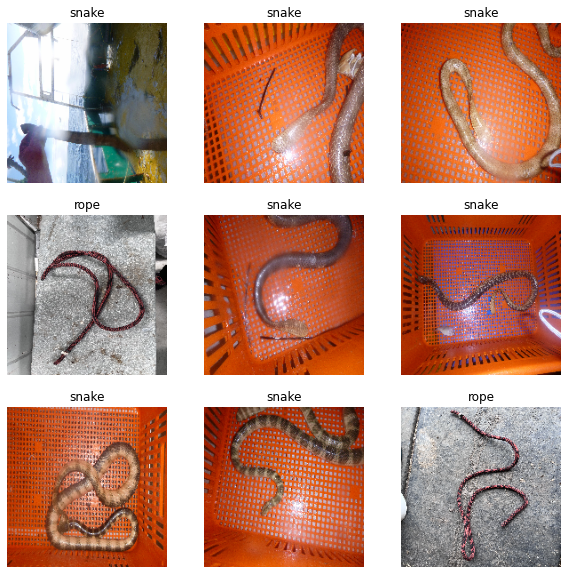

In [8]:
# We can have a look at the first 9 images from the training dataset: 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
with tf.device('/CPU:0'):
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
      ]
    )

In [11]:
num_classes = len(class_names)

inputs = keras.Input(shape = (180,180,3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x) #The first layer is a normal conv2D layer, as RGB colour channels are highly correlated. We will start using SeparableConv2D afterwards. 

for size in [32, 64, 128, 256, 512]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    
    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])
    
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation = "sigmoid")(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
    
    

In [12]:
model.compile(optimizer='adam',      # 'adam' is an adaptive optimiser which is good with sparse datasets 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # computes crossentropy loss between labels and predictions. Use when there are two or more label classes are integers rather than binary or one-hot encoded. 
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 176, 176, 32) 2400        rescaling[0][0]                  
______________________________________________________________________________________________

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet_from_scratch_updated.keras",
        save_best_only = True, 
        monitor = "val_loss")
]

In [15]:
epochs = 200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/200


2022-01-21 15:59:26.335868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-21 15:59:36.501328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 253 of 256
2022-01-21 15:59:36.688813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-01-21 15:59:37.771261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-01-21 15:59:46.924520: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 8 of 1000
2022-01-21 15:59:56.997799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 15 of 1000
2022-01-21 16:00:07.838879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 23 of 100

34/34 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.8284

2022-01-21 16:00:34.172507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-21 16:00:44.333582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 238 of 256
2022-01-21 16:00:45.085610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


34/34 [==============================] - 81s 944ms/step - loss: 0.5890 - accuracy: 0.8284 - val_loss: 0.6712 - val_accuracy: 0.5261
Epoch 2/200


/Users/esbishop/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


34/34 [==============================] - 19s 548ms/step - loss: 0.5527 - accuracy: 0.9571 - val_loss: 0.7292 - val_accuracy: 0.5224
Epoch 3/200
34/34 [==============================] - 19s 551ms/step - loss: 0.5417 - accuracy: 0.9534 - val_loss: 0.7381 - val_accuracy: 0.5224
Epoch 4/200
34/34 [==============================] - 18s 535ms/step - loss: 0.5307 - accuracy: 0.9450 - val_loss: 0.7459 - val_accuracy: 0.5224
Epoch 5/200
34/34 [==============================] - 18s 536ms/step - loss: 0.5131 - accuracy: 0.9692 - val_loss: 0.7528 - val_accuracy: 0.5224
Epoch 6/200
34/34 [==============================] - 18s 537ms/step - loss: 0.5008 - accuracy: 0.9683 - val_loss: 0.7592 - val_accuracy: 0.5224
Epoch 7/200
34/34 [==============================] - 18s 526ms/step - loss: 0.4922 - accuracy: 0.9655 - val_loss: 0.7646 - val_accuracy: 0.5224
Epoch 8/200
34/34 [==============================] - 18s 528ms/step - loss: 0.4834 - accuracy: 0.9571 - val_loss: 0.7682 - val_accuracy: 0.5224
Epoc

34/34 [==============================] - 21s 622ms/step - loss: 0.2689 - accuracy: 0.9412 - val_loss: 0.8380 - val_accuracy: 0.5522
Epoch 59/200
34/34 [==============================] - 21s 612ms/step - loss: 0.2318 - accuracy: 0.9627 - val_loss: 0.3210 - val_accuracy: 0.8993
Epoch 60/200
34/34 [==============================] - 21s 603ms/step - loss: 0.2250 - accuracy: 0.9646 - val_loss: 0.5526 - val_accuracy: 0.7463
Epoch 61/200
34/34 [==============================] - 20s 592ms/step - loss: 0.2305 - accuracy: 0.9599 - val_loss: 0.7369 - val_accuracy: 0.6269
Epoch 62/200
34/34 [==============================] - 20s 578ms/step - loss: 0.2181 - accuracy: 0.9655 - val_loss: 0.3282 - val_accuracy: 0.9030
Epoch 63/200
34/34 [==============================] - 19s 564ms/step - loss: 0.2386 - accuracy: 0.9515 - val_loss: 0.1860 - val_accuracy: 0.9851
Epoch 64/200
34/34 [==============================] - 19s 557ms/step - loss: 0.3584 - accuracy: 0.8881 - val_loss: 0.5893 - val_accuracy: 0.772

34/34 [==============================] - 17s 514ms/step - loss: 0.2836 - accuracy: 0.9198 - val_loss: 0.2831 - val_accuracy: 0.9254
Epoch 115/200
34/34 [==============================] - 18s 529ms/step - loss: 0.2709 - accuracy: 0.9328 - val_loss: 0.2763 - val_accuracy: 0.9291
Epoch 116/200
34/34 [==============================] - 18s 524ms/step - loss: 0.3063 - accuracy: 0.9021 - val_loss: 0.5627 - val_accuracy: 0.6866
Epoch 117/200
34/34 [==============================] - 17s 514ms/step - loss: 0.3551 - accuracy: 0.8535 - val_loss: 0.5631 - val_accuracy: 0.6866
Epoch 118/200
34/34 [==============================] - 18s 521ms/step - loss: 0.3661 - accuracy: 0.8451 - val_loss: 0.5314 - val_accuracy: 0.7127
Epoch 119/200
34/34 [==============================] - 18s 519ms/step - loss: 0.2897 - accuracy: 0.9142 - val_loss: 0.2311 - val_accuracy: 0.9813
Epoch 120/200
34/34 [==============================] - 18s 538ms/step - loss: 0.2680 - accuracy: 0.9366 - val_loss: 0.2050 - val_accuracy:

34/34 [==============================] - 18s 520ms/step - loss: 0.1697 - accuracy: 0.9664 - val_loss: 0.3374 - val_accuracy: 0.8694
Epoch 171/200
34/34 [==============================] - 18s 522ms/step - loss: 0.1719 - accuracy: 0.9646 - val_loss: 0.3651 - val_accuracy: 0.8545
Epoch 172/200
34/34 [==============================] - 18s 521ms/step - loss: 0.1457 - accuracy: 0.9757 - val_loss: 0.4072 - val_accuracy: 0.8321
Epoch 173/200
34/34 [==============================] - 18s 520ms/step - loss: 0.1731 - accuracy: 0.9664 - val_loss: 0.4026 - val_accuracy: 0.8358
Epoch 174/200
34/34 [==============================] - 18s 520ms/step - loss: 0.1662 - accuracy: 0.9683 - val_loss: 0.3902 - val_accuracy: 0.8433
Epoch 175/200
34/34 [==============================] - 18s 521ms/step - loss: 0.1650 - accuracy: 0.9683 - val_loss: 0.3851 - val_accuracy: 0.8470
Epoch 176/200
34/34 [==============================] - 18s 520ms/step - loss: 0.1778 - accuracy: 0.9627 - val_loss: 0.3870 - val_accuracy:

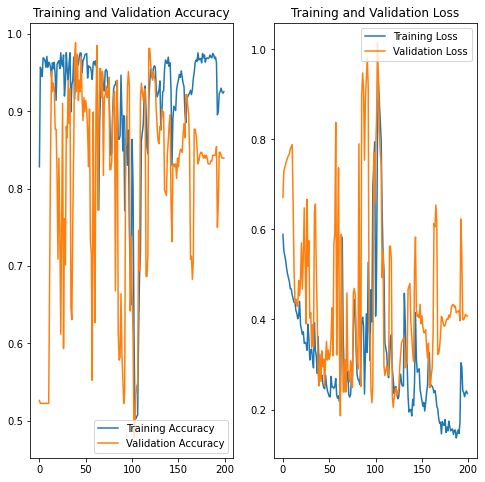

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
test_model = keras.models.load_model("convnet_from_scratch_updated.keras") 
test_loss, test_acc = test_model.evaluate(test_ds) 
print(f"Test accuracy: {test_acc:.3f}")

2022-01-21 21:52:55.407351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 152ms/step - loss: 0.2108 - accuracy: 0.9745
Test accuracy: 0.975
